# Amazon Reviews for Sentiment Analysis

## Objective

Here we will be Building ML and DL models to predict the Polarity of reviews.
We will be performing series of experiments with different models to achieve the best classification metrics.(while not abusing the machine we have)

## About Dataset 
[Dataset here](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews)


### OVERVIEW
Contains 34,686,770 Amazon reviews from 6,643,669 users on 2,441,053 products, from the Stanford Network Analysis Project (SNAP). This subset contains 1,800,000 training samples and 200,000 testing samples in each polarity sentiment.

### ORIGIN
The Amazon reviews dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. For more information, please refer to the following paper: J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013.

### DESCRIPTION
The Amazon reviews polarity dataset is constructed by taking review score 1 and 2 as negative, and 4 and 5 as positive. Samples of score 3 is ignored. In the dataset, class 1 is the negative and class 2 is the positive. Each class has 1,800,000 training samples and 200,000 testing samples.

If you need help extracting the train.csv and test.csv files check out the starter code.

The files train.csv and test.csv contain all the training samples as comma-separated values.

The CSVs contain polarity, title, text. These 3 columns in them, correspond to class index (1 or 2), review title and review text.

polarity - 1 for negative and 2 for positive
title - review heading
text - review body
The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [1]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.layers import Embedding ,LSTM, Dense, Dropout, Conv1D, MaxPool1D, BatchNormalization, TextVectorization
import matplotlib.pyplot as plt

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')


##importing useful functions
!git clone https://github.com/tikendraw/funcyou.git
from funcyou.metrics import calculate_results
# from funcyou.plot import plot_history, compare_histories
from funcyou.dataset import download_kaggle_dataset

# !pip install tensorflow_hub
import tensorflow_hub as hub
import os
import re
import json

print('Tf version: ',tf.__version__)
print('GPU: ', len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


def download_USEncoder():

    print('downloading universal sentence encoder...')
    !wget https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
    print('Downloaded universal sentence encoder.')
    # Extracting
    try:
        !mkdir universal_sentence_encoder
        print('Extracting universal sentence encoder....')
        ! tar -xf 4.tar.gz --directory ./universal_sentence_encoder
        print('Extracted.')
    except Exception as e:
        print(e)


2022-11-28 16:39:05.939367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 16:39:06.088255: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 16:39:06.727846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf/lib/
2022-11-28 16:39:06.727929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.

/bin/bash: /home/t/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'funcyou' already exists and is not an empty directory.
Tf version:  2.10.0
GPU:  1


2022-11-28 16:39:09.605066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 16:39:09.669329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 16:39:09.669939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Download the data if you don't have locally
data_url = 'https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews'

def download_data(data_url):
    download_kaggle_dataset(url = data_url)
    print('Dataset Downloaded.')
    # #extract 
    print('Extracting...')
    ! mkdir dataset
    !unzip amazon-reviews.zip -d dataset
    print('Extracted.')


In [3]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    download_USEncoder()
    download = input('Did you upload kaggle.json?(Yes/No) ')
    if download in ['yes','Yes','Y','y']:
        print('Dataset Downloading...')
        download_data(data_url)
    
else:
  print('Not running on CoLab')


Did you upload kaggle.json?(Yes/No)  n


Not running on CoLab


In [4]:
embed = hub.KerasLayer("./universal_sentence_encoder")

2022-11-28 16:41:16.761587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 16:41:16.762177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 16:41:16.762400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 16:41:16.762549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Load the data

In [5]:
CHUNKSIZE = 1_000_000

In [6]:
#reading data
tp = pd.read_csv('./dataset/train.csv',names = ['polarity', 'title','text'], iterator=True, chunksize=CHUNKSIZE)  # gives TextFileReader, which is iterable with chunks of 1000 rows.
#joining the chunks
df = pd.concat(tp, ignore_index=True)
#print info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   title     object
 2   text      object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
None


In [7]:
# check for nulls and drop if any
df.isnull().sum()

polarity     0
title       77
text         0
dtype: int64

In [8]:
#dropping 77 null titles
df.dropna(axis = 0, how = 'any', inplace = True)

In [9]:
# checking for classs imbalance
df['polarity'].value_counts()

2    1799965
1    1799958
Name: polarity, dtype: int64

**Note:** The dataset is fairly large, we will use tensorflow's data api to load and handle the data

# We will map the polarity between 0 for negative sentiment to 1 for positive sentiment

In [10]:
df['polarity'] = df['polarity'].map({1:0, 2:1})
df['polarity'] = df['polarity'].astype(np.int8)

In [11]:
df.sample(10)

,polarity,title,text
1264585,1,Can't get enough of this....,SAHB at their zany best. A very light sound co...
3541712,0,I Love Maria (aka Roboforce),"Not a bad film, with a lot of fx effects and a..."
1255378,1,Good value for price,"While this is not a Sony or Panasonic, it does..."
346691,0,The Last Rakosh,This is a rip off. This is word for word taken...
664345,0,no wonder know one has heard of him,"this is the worst album ever, it should not ev..."
2368332,1,harkens back to classics,I am overwhelmed the beautiful melodic tones o...
63591,0,"Overlong, slack and indulgent",Some thoughts:- It is possible for a movie to ...
668097,1,classic must have movie,this is a classic movie and i am so glad to ha...
2647694,1,"Extradinary, Diffirent, (Actually, I'm not rev...",This not a review just a message about the nam...
3304958,0,Terrible!,Jurrasic Park had the excitement of pushing th...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599923 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int8  
 1   title     object
 2   text      object
dtypes: int8(1), object(2)
memory usage: 85.8+ MB


## Note: We will be combining text and title columns . makes more sense.

In [13]:
#preprocessing functions to clear punctuations, lower strings, remove special chars removing contractions
from funcyou.preprocessing.text import  text_cleaning_apos, cont_to_exp, text_cleaning


def clean_all(text):
    text = text_cleaning_apos(text)
    text = cont_to_exp(text)
    text = text_cleaning(text)
    return text

In [14]:
%%time
print('Started at: ',datetime.datetime.now().strftime("%H:%M:%S"))
print('This cell takes 10 minutes to process 3.6M data')
#joining columns and cleaning the text 
df['review'] = df['title']+' ' + df['text']
# df['review'] = df['review'].apply(clean_all)
df['review'] = df['review'].astype(np.object_)


Started at:  16:41:56
This cell takes 10 minutes to process 3.6M data
CPU times: user 1.3 s, sys: 1.08 s, total: 2.38 s
Wall time: 2.62 s


In [15]:
df.review.sample(1).values.dtype

dtype('O')

In [16]:
df.head()

,polarity,title,text,review
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,Stuning even for the non-gamer This sound trac...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,The best soundtrack ever to anything. I'm read...
2,1,Amazing!,This soundtrack is my favorite music of all ti...,Amazing! This soundtrack is my favorite music ...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,Excellent Soundtrack I truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...","Remember, Pull Your Jaw Off The Floor After He..."


A dataframe to store results

In [17]:
#creating a dataframe to store results
all_result = pd.DataFrame(columns=['model','accuracy','precision','recall','f1','discription'])

In [18]:
def add_to_big_result(res:dict):
    global all_result
    res = pd.DataFrame([res])
    all_result = pd.concat([all_result, res], ignore_index=True)
    print(all_result)
    return all_result

# Data Preparation

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split( df[['review']], df['polarity'], test_size=  .001, stratify=df['polarity'], random_state = 89)
xtrain, xval, ytrain, yval = train_test_split( xtrain, ytrain, test_size=  .05, stratify=ytrain,random_state = 89)

print('xtrain shape',xtrain.shape, 'ytrain shape', ytrain.shape)
print('xtest shape',xtest.shape, 'ytest shape', ytest.shape)
print('xval shape',xval.shape, 'yval shape', yval.shape)

xtrain shape (3416506, 1) ytrain shape (3416506,)
xtest shape (3600, 1) ytest shape (3600,)
xval shape (179817, 1) yval shape (179817,)


In [20]:
del(df) # deleting variables to keep the memory free
xtrain.head()

,review
2609501,stinks I tried to set this up on my system and...
2474900,A saint in our lifetime Saints aren't just tho...
2243902,"Just buy the CD ""Revival"" I was sooooo excited..."
14778,Had potential but didn't reach it I'm just an ...
1522869,"TH excellent mais vous me ,pétez les couilles ..."


In [21]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3416506 entries, 2609501 to 3354793
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   review  object
dtypes: object(1)
memory usage: 52.1+ MB


In [22]:
ytrain.head()

2609501    0
2474900    1
2243902    0
14778      0
1522869    1
Name: polarity, dtype: int8

# Creating tensorflow dataset using `tf.data` api

In [23]:
xtrain.head()

,review
2609501,stinks I tried to set this up on my system and...
2474900,A saint in our lifetime Saints aren't just tho...
2243902,"Just buy the CD ""Revival"" I was sooooo excited..."
14778,Had potential but didn't reach it I'm just an ...
1522869,"TH excellent mais vous me ,pétez les couilles ..."


In [24]:
BATCH_SIZE = 32

#train
train_feature = tf.data.Dataset.from_tensor_slices(xtrain)
train_label = tf.data.Dataset.from_tensor_slices(ytrain)
#test
test_feature = tf.data.Dataset.from_tensor_slices(xtest)
test_label = tf.data.Dataset.from_tensor_slices(ytest)
#val
val_feature = tf.data.Dataset.from_tensor_slices(xval)
val_label = tf.data.Dataset.from_tensor_slices(yval)

In [25]:
for i in train_feature.take(1):
    print(i)
    break

tf.Tensor([b'stinks I tried to set this up on my system and failed. I called the customere service center and spent two hours, they failed. I had a visit by a local tech who can fix anything, he failed. Why they sell the product is a deep question that ranks up there with why we exist.'], shape=(1,), dtype=string)


In [26]:
for i in train_label.take(1):
    print(i)
    break

tf.Tensor(0, shape=(), dtype=int8)


In [27]:
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.zip((train_feature, train_label))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.zip((test_feature, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.zip((val_feature, val_label))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
del(train_feature, train_label, test_feature, test_label, val_feature, val_label) # deleting variables to keep the memory free

In [29]:
print('len train dataset: ', len(train_dataset))
print('len test dataset: ', len(test_dataset))
print('len val dataset: ', len(val_dataset))

len train dataset:  213532
len test dataset:  225
len val dataset:  11239


# Model:0 (Naive bayes model)

In [30]:
model0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('multino',MultinomialNB())
])

In [31]:
%%time
#fit and predict
# model0.fit(xtrain['review'], ytrain)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [32]:
# pred0 = model0.predict(xtest['review'])

# print(pred0.shape ==  ytest.shape)
# print('pred00.shape: ',pred0.shape)
# print('ytest.shape: ',ytest.shape)

# model0_res = calculate_results(y_true=ytest, y_pred=pred0, model_name='model0: naive bayes')
# print(model0_res)

In [33]:
# preditions on texts is more accurate than titles, simply because there is more words and combinations which describes the sentiments better.

In [34]:
# all_result =add_to_big_result(model0_res)

# Text vectorization

In [35]:
# MAX_TOKEN = 1_00_00
# OUTPUT_SEQUENCE_LENGTH = 200  # limiting reviews to 200 words

In [36]:
# text_vectorizer = TextVectorization(max_tokens=MAX_TOKEN, standardize='lower_and_strip_punctuation',
#                                    split='whitespace',
#                                     ngrams= None ,
#                                     output_mode='int',
#                                     output_sequence_length=OUTPUT_SEQUENCE_LENGTH, 
#                                     pad_to_max_tokens=False)

In [37]:
# %%time
# #adapting to training data
# print("cell takes: ")
# text_vectorizer.adapt(train_feature)

# random_review = df['review'].sample(n = 1).values
# print('random Review: ', random_review)
# print('random Review length: ', len(random_review))
# print('-------\n')
# print('vectorized review: ',text_vectorizer(random_review))
# print('-------\n')
# print('Vocabulary_length: ',len(text_vectorizer.get_vocabulary()))
# print('Most frequent words: ',text_vectorizer.get_vocabulary()[:10])
# print('least frequent words: ',text_vectorizer.get_vocabulary()[-10:])

# Embedding

In [38]:
# embedding = Embedding(input_dim = MAX_TOKEN,output_dim= 32, mask_zero=True, input_length=OUTPUT_SEQUENCE_LENGTH)
# print('Embedded text vectorized random sentence: ',embedding(text_vectorizer(random_review)))

# Model1

In [39]:
# inputs  = keras.Input(shape= (1), dtype = tf.string)
# vectorizer_layer  = text_vectorizer(inputs)
# embedding_layer  = embedding(vectorizer_layer)

# x = LSTM(16, return_sequences=True)(embedding_layer)
# # x = LSTM(32, return_sequences=True)(x)
# x = LSTM(16)(x)
# x = Dropout(.4)(x)
# x = Dense(64, activation='relu')(x)
# outputs = Dense(1, activation = 'sigmoid')(x)

# #building model
# model1 = keras.Model(inputs = inputs, outputs = outputs, name = 'model1_lstm')

# #compiling model
# model1.compile(loss = keras.losses.binary_crossentropy,
#               optimizer = keras.optimizers.Adam(),
#               metrics = ['accuracy'])

In [40]:
# EPOCHS = 5
# print(len(train_dataset), len(val_dataset))

In [41]:
# %%time

#fit the model
# history1 = model1.fit(train_dataset, epochs = EPOCHS, 
#                       validation_data= val_dataset, 
#                       steps_per_epoch=int(.1*(len(train_dataset) / EPOCHS)),
#                       validation_steps=int(.1*(len(val_dataset) / EPOCHS)))

In [42]:
#@title Plot history function
def plot_history1(history, plot = ['loss','accuracy'], split = ['train','val'], epoch:int = None, figsize = (20,10),colors = ['r','b'], **plot_kwargs ):
    
    ''' Plots History

    Arguments:
    ###############
    histroy 	:	History to plot
    plot:list	:   what to plot (what metrics you want to compare)  -> ['loss', 'accuracy']  
    split:list  :   what split to compare -> ['train', 'val']
    epoch:int   :   for how many epochs to comapre (cannot be greater than highest epoch of histories)
    figsize:tuple:  size of plot
    plot_kwargs :   kwargs to plt.plot to customize plot

    Returns:
    ##############
    Plots history 

    '''

    try:
        import matplotlib as mpl
        mpl.rcParams['figure.dpi'] = 500
        
        if not len(colors) == len(split):
            raise ValueError('not enogh colors')
        
        cols = []
        for i in plot:
            for j in split:
                if j == 'val':
                    cols.append(j+'_'+i)
                else:
                    cols.append(i)
        
        #compare to epoch
        if epoch is None:
            epoch = history.epoch

        def display(col, plot_num, history, epoch:int = None,label = None, **plot_kwargs):
            plt.subplot(len(plot),len(split),plot_num)
            plt.grid(True)
            
            if epoch == None:
                epoch = history.epoch
            
            if label is None:
                label=history.model.name
                
            plt.plot(epoch, pd.DataFrame(history.history)[col], label=label, **plot_kwargs)
            plt.title((' '.join(col.split('_'))).upper())
            plt.xlabel('epochs')
            plt.legend()
        
        plt.figure(figsize = figsize)
        plot_title = " ".join(plot).upper()+" PLOT"
        plt.suptitle(plot_title)

        for plot_num,col in enumerate(plot,1):
            display(col, plot_num, history, epoch, label = 'train',color = colors[0], **plot_kwargs)
            if 'val' in split:
                display('val_'+col, plot_num, history, epoch,label = 'val' ,color = colors[1])
    except Exception as e:
        print('Error Occured: ',e)


In [43]:
#plot history
# plot_history1(history1, plot=['loss','accuracy'], figsize=(15,5))

#### Evaluation

In [44]:
# ypred1 = tf.squeeze(tf.round(model1.predict(xtest)))
# print('ypred1.shape: ',ypred1.shape)

# model1_res = calculate_results(ytest,ypred1, model_name='model1: LSTM', discription = 'small lstm model with vectorizer and embedding layer')
# print(model1_res)

## adding result to all_result 
# all_result = add_to_big_result(model1_res)

#### saving the model

In [45]:
# model2.save('./drive/MyDrive/amazon_review/saved_models/model2_lstm_use_layer.tf', save_format='tf')

In [46]:
#load the saved model
# model1_loaded = keras.models.load_model('./saved_models/model1_lstm.tf')

In [47]:
# ypred11 = tf.squeeze(tf.round(model1_loaded.predict(xtest)))
# model11_res = calculate_results(ytest,ypred11, model_name='model1: LSTM loaded')
# print(model11_res)
# all_result = add_to_big_result(model11_res)

# Model2

In [30]:
inputs = keras.Input(shape = [], dtype = 'string')
use_layer = embed(inputs)
print(use_layer.shape)
use_layer = tf.expand_dims(use_layer, axis = 1)
print(use_layer.shape) 
x = LSTM(32, return_sequences=True)(use_layer)
# x = LSTM(32, return_sequences=True)(x)
x = LSTM(16)(x)
x = Dropout(.4)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

#building model
model2 = keras.Model(inputs = inputs, outputs = outputs, name = 'model2_use_layer')

#compiling model
model2.compile(loss = keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

(None, 512)
(None, 1, 512)


In [49]:
# from funcyou.callbacks import create_model_checkpoint
def create_model_checkpoint(model_name, save_dir, monitor:str = 'val_loss',verbose: int = 0, save_best_only: bool = True, save_weights_only: bool = False,
                            mode: str = 'auto', save_freq='epoch', options=None, initial_value_threshold=None, **kwargs):
    model_name = model_name+'-'+ str(datetime.datetime.now())
    dir = os.path.join(save_dir, model_name)

    if not os.path.exists(dir):
        os.makedirs(dir)

    return tf.keras.callbacks.ModelCheckpoint(
                                                dir,
                                                monitor = monitor,
                                                verbose = verbose,
                                                save_best_only = save_best_only,
                                                save_weights_only = save_weights_only,
                                                mode = mode,
                                                save_freq = save_freq,
                                                options=options,
                                                initial_value_threshold = initial_value_threshold,
                                                **kwargs)


In [50]:
# EPOCHS = 100
# print(len(train_dataset), len(val_dataset))

213532 11239


In [51]:
# del(train_dataset, test_dataset, val_dataset)

In [ ]:
# %%time
# #fit the model
# history2 = model2.fit(train_dataset, epochs = EPOCHS, 
#                       validation_data= val_dataset, 
#                       steps_per_epoch=int((len(train_dataset) / EPOCHS)),
#                       validation_steps=int(1*(len(val_dataset) / EPOCHS)),
#                       callbacks = [
#                                     create_model_checkpoint(model_name = 'model2:use_lstm', 
#                                     save_dir = '/content/drive/MyDrive/amazon_review/', 
#                                     monitor = 'val_accuracy',
#                                     save_best_only = True, 
#                                     save_weights_only = True,
#                                         mode= 'auto', save_freq='epoch')]
#                       )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


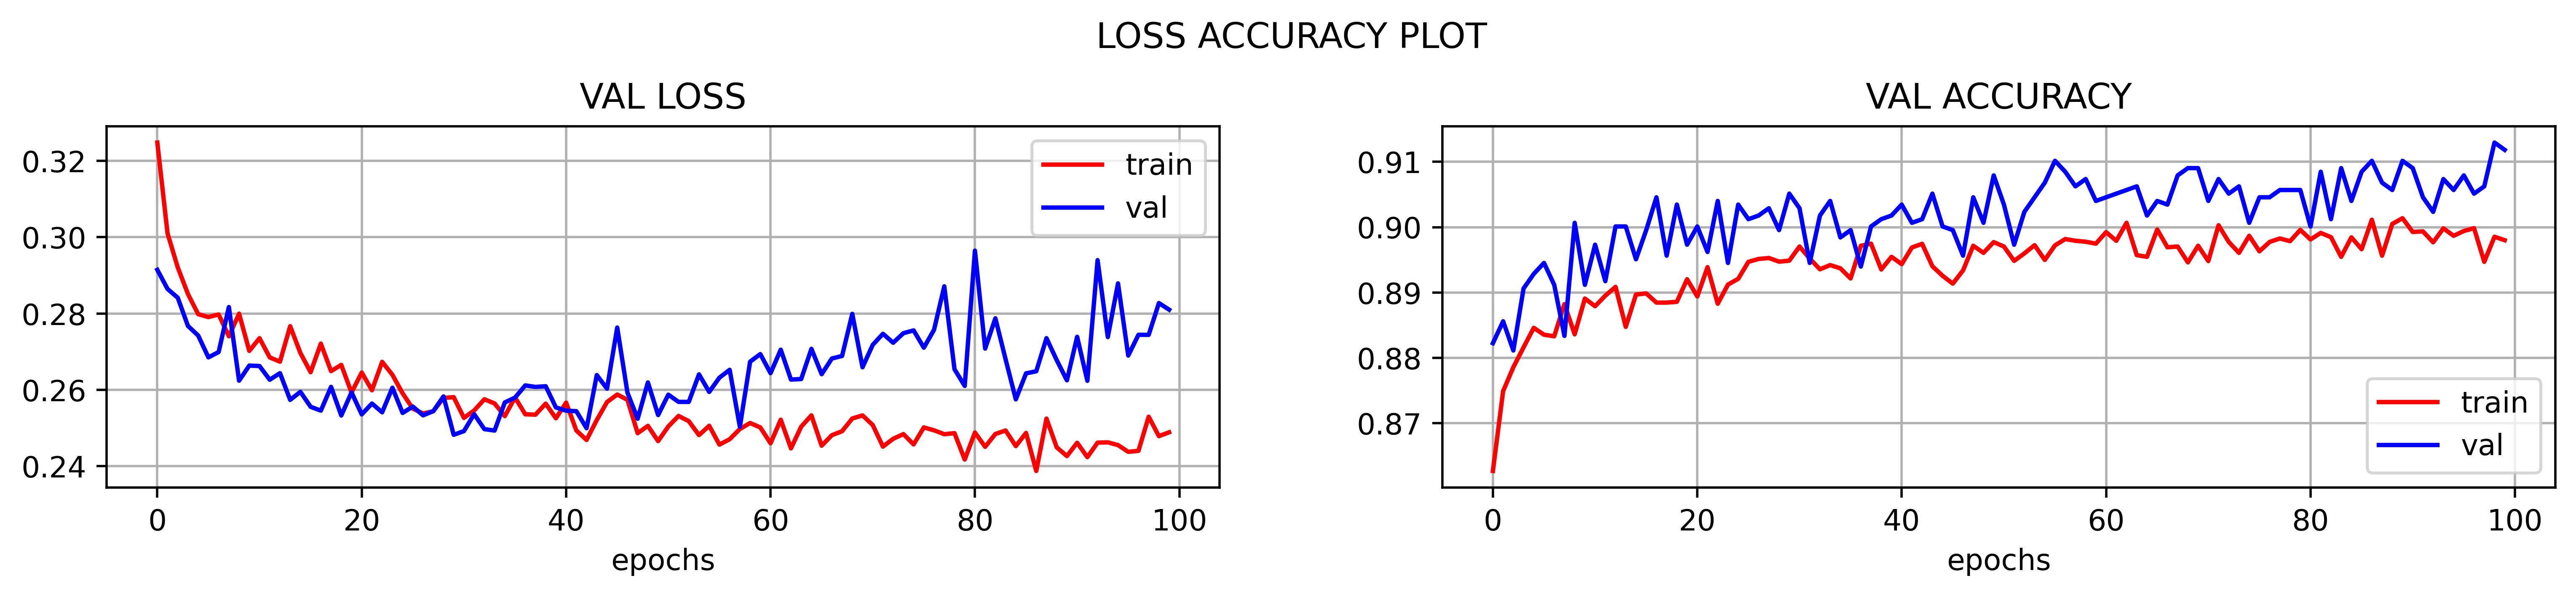

In [53]:
# plot_history
# plot_history1(history2, plot=['loss','accuracy'], figsize=(15,5))

In [38]:
model2.load_weights('./amazon_review-20221127T193218Z-001/amazon_review/model2_use_lstm-2022-11-27 06_40_52.876175')

#### Evaluation

In [39]:
ypred2 = tf.squeeze(tf.round(model2.predict(test_dataset,
                                            use_multiprocessing=True)))
print('ypred2.shape: ',ypred2.shape)

ytest_true = [y for x,y in test_dataset.unbatch()]
print('ypred2.shape: ',len(ytest_true))

model2_res = calculate_results(np.array(ytest_true),ypred2, model_name='model2: use layer lstm')
print('model2_res: ',model2_res)

all_result = add_to_big_result(model2_res)

error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
2022-11-28 16:48:42.779317: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: JIT compilation failed.


UnknownError: Graph execution error:

JIT compilation failed.
	 [[{{node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/embedding_lookup/mod}}]] [Op:__inference_predict_function_8151]

3600

model2_res:  {'model': 'model2: use layer lstm', 'accuracy': 89.61111111111111, 'precision': 0.896551724137931, 'recall': 0.8961111111111111, 'f1': 0.8960822450680744, 'discription': None}
                    model   accuracy  precision    recall        f1  \
0  model2: use layer lstm  89.611111   0.896552  0.896111  0.896082   

  discription  
0        None  


# Model3: Conv1D

In [ ]:
inputs = layers.Input(shape=(1,), dtype = 'string')
vect_layer = text_vectorizer(inputs)
embed_layer = embed(vect_layer)
x = layers.Conv1D(64,3,1,padding = 'same',activation = 'relu')(embed_layer)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling1D()(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation = 'softmax')(x)


inputs = keras.Input(shape = [], dtype = 'string')
use_layer = embed(inputs)
print(use_layer.shape)
use_layer = tf.expand_dims(use_layer, axis = 1)
print(use_layer.shape) 
x = LSTM(32, return_sequences=True)(use_layer)
# x = LSTM(32, return_sequences=True)(x)
x = LSTM(16)(x)
x = Dropout(.4)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

#building model
model2 = keras.Model(inputs = inputs, outputs = outputs, name = 'model2_use_layer')

#compiling model
model2.compile(loss = keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])